# QuantAlpha Engine — 因子回测框架完整演示（真实数据版）

**框架结构：**
```
quant_alpha_engine/
├── data/mock_generator.py   # 模拟数据生成器（GBM + 行业共同因子）
├── ops/alpha_ops.py         # 全部算子库（时序 + 截面 + 特殊）
├── backtest/
│   ├── performance.py       # 绩效指标计算
│   └── vector_engine.py     # 矩阵式净值回测引擎
└── visualization/report.py  # Matplotlib 6子图报告
```

**工作流：**
```
真实数据加载 → 数据完整性过滤 → 数据统计 → 算子构造因子 → VectorEngine 回测 → 指标 + 绘图
```

**数据说明：**
- 数据来源：`rawdata/repository`（本地 DataRepository，约 286 只 A 股日线）
- **过滤规则**：仅保留 ① close 数据完整（NaN = 0）且 ② 有申万一级行业信息的股票
- **最终宇宙**：约 257 只股票，覆盖 26 个申万一级行业，时间范围 2025-02-26 ~ 2026-02-26

## 0. 环境准备

In [1]:
# 确认当前工作目录（需要在 quant_alpha_engine 的父目录下运行）
import os
print('当前路径:', os.getcwd())

# 如果路径不对，取消注释并修改以下行：
# os.chdir(r'D:\Stock\Frame')  # ← 修改为实际路径

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# Jupyter 内联显示图表
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

当前路径: d:\2026_claude\StockFrame


## 1. 导入框架

In [2]:
from data_loader import RepositoryDataLoader, MarketData
from quant_alpha_engine.ops import AlphaOps as op
from quant_alpha_engine.backtest import VectorEngine
from quant_alpha_engine.backtest.performance import Performance

print('✅ QuantAlpha Engine 导入成功')

✅ QuantAlpha Engine 导入成功


## 2. 加载真实市场数据

使用 **RepositoryDataLoader** 从本地仓库加载真实 A 股数据，并进行以下过滤：
- ✅ 数据完整：close 价格无缺失（NaN 比例 = 0）
- ✅ 行业完整：股票在申万行业分类中有记录（sw1_name 非 Unknown）
- ✅ 交易日充足：至少 200 个有效交易日

In [3]:
# ── 数据配置 ──────────────────────────────────────────────────
REPO_DIR   = './rawdata/repository'   # DataRepository 根目录
START_DATE = '2025-02-26'             # 回测起始日期
END_DATE   = '2026-02-26'             # 回测截止日期（None = 今天）
ADJ_TYPE   = 'hfq'                    # 'hfq'(后复权，推荐) | 'qfq'(前复权) | 'raw'(不复权)

# ── 数据过滤参数 ─────────────────────────────────────────────
MIN_TRADING_DAYS = 200     # 最少有效交易日，不足则剔除
MAX_NAN_PCT      = 0.0     # close 列最大允许 NaN 比例（0 = 严格无缺失）

# ── Step 1: 加载全部股票原始数据 ─────────────────────────────
print('► Step 1: 从仓库加载全部 OHLCV 数据...')
loader = RepositoryDataLoader(
    repo_dir     = REPO_DIR,
    limit_up_pct = 0.099,   # 涨跌停判断阈值（科创板/创业板可改为 0.199）
)

data_raw = loader.load(
    symbols          = None,              # None = 自动加载仓库中所有股票
    start_date       = START_DATE,
    end_date         = END_DATE,
    adj_type         = ADJ_TYPE,
    fill_suspended   = True,              # 停牌日用前值填充价格
    min_trading_days = MIN_TRADING_DAYS,  # 剔除数据不足的股票
)
print(f'  原始加载：{data_raw.close.shape[1]} 只股票 × {data_raw.close.shape[0]} 个交易日')

# ── Step 2: 过滤 close 数据完整的股票 ────────────────────────
print('\n► Step 2: 过滤 close 数据完整的股票...')
nan_pct = data_raw.close.isnull().mean(axis=0)  # 每只股票的 NaN 比例
valid_data = nan_pct[nan_pct <= MAX_NAN_PCT].index.tolist()
print(f'  NaN ≤ {MAX_NAN_PCT*100:.0f}%：{len(valid_data)} 只股票通过')

# ── Step 3: 过滤有完整行业信息的股票 ─────────────────────────
print('\n► Step 3: 过滤有完整申万行业信息的股票...')
has_industry = data_raw.industry[data_raw.industry != 'Unknown'].index.tolist()
print(f'  有行业信息（非 Unknown）：{len(has_industry)} 只股票通过')

# ── Step 4: 取交集，得到最终宇宙 ─────────────────────────────
valid_symbols = sorted(set(valid_data) & set(has_industry))
print(f'\n► Step 4: 最终宇宙（数据完整 ∩ 有行业信息）：{len(valid_symbols)} 只股票')

# ── Step 5: 从原始数据中截取最终宇宙的各矩阵 ─────────────────
close    = data_raw.close[valid_symbols]
open_    = data_raw.open[valid_symbols]
high     = data_raw.high[valid_symbols]
low      = data_raw.low[valid_symbols]
volume   = data_raw.volume[valid_symbols]
industry = data_raw.industry[valid_symbols]
is_susp  = data_raw.is_suspended[valid_symbols]
is_limit = data_raw.is_limit[valid_symbols]

print(f'\n✅ 数据加载完成！')
print(f'   收盘价矩阵 : {close.shape}  (交易日 × 股票)')
print(f'   日期范围   : {close.index[0].date()} ~ {close.index[-1].date()}')
print(f'   复权方式   : {ADJ_TYPE}')

[000001] 无复权数据，使用 hfq_factor=1.0
[000002] 无复权数据，使用 hfq_factor=1.0
[000063] 无复权数据，使用 hfq_factor=1.0
[000100] 无复权数据，使用 hfq_factor=1.0
[000157] 无复权数据，使用 hfq_factor=1.0
[000166] 无复权数据，使用 hfq_factor=1.0
[000301] 无复权数据，使用 hfq_factor=1.0
[000333] 无复权数据，使用 hfq_factor=1.0
[000338] 无复权数据，使用 hfq_factor=1.0
[000408] 无复权数据，使用 hfq_factor=1.0
[000425] 无复权数据，使用 hfq_factor=1.0
[000538] 无复权数据，使用 hfq_factor=1.0
[000568] 无复权数据，使用 hfq_factor=1.0
[000596] 无复权数据，使用 hfq_factor=1.0
[000617] 无复权数据，使用 hfq_factor=1.0
[000625] 无复权数据，使用 hfq_factor=1.0
[000630] 无复权数据，使用 hfq_factor=1.0
[000651] 无复权数据，使用 hfq_factor=1.0
[000661] 无复权数据，使用 hfq_factor=1.0
[000708] 无复权数据，使用 hfq_factor=1.0
[000725] 无复权数据，使用 hfq_factor=1.0
[000768] 无复权数据，使用 hfq_factor=1.0
[000776] 无复权数据，使用 hfq_factor=1.0
[000786] 无复权数据，使用 hfq_factor=1.0
[000792] 无复权数据，使用 hfq_factor=1.0
[000800] 无复权数据，使用 hfq_factor=1.0
[000807] 无复权数据，使用 hfq_factor=1.0
[000858] 无复权数据，使用 hfq_factor=1.0
[000876] 无复权数据，使用 hfq_factor=1.0
[000895] 无复权数据，使用 hfq_factor=1.0
[000938] 无

► Step 1: 从仓库加载全部 OHLCV 数据...


[000999] 无复权数据，使用 hfq_factor=1.0
[001289] 无复权数据，使用 hfq_factor=1.0
[001391] 无复权数据，使用 hfq_factor=1.0
[001965] 无复权数据，使用 hfq_factor=1.0
[001979] 无复权数据，使用 hfq_factor=1.0
[002001] 无复权数据，使用 hfq_factor=1.0
[002027] 无复权数据，使用 hfq_factor=1.0
[002028] 无复权数据，使用 hfq_factor=1.0
[002050] 无复权数据，使用 hfq_factor=1.0
[002074] 无复权数据，使用 hfq_factor=1.0
[002129] 无复权数据，使用 hfq_factor=1.0
[002142] 无复权数据，使用 hfq_factor=1.0
[002179] 无复权数据，使用 hfq_factor=1.0
[002180] 无复权数据，使用 hfq_factor=1.0
[002230] 无复权数据，使用 hfq_factor=1.0
[002236] 无复权数据，使用 hfq_factor=1.0
[002241] 无复权数据，使用 hfq_factor=1.0
[002252] 无复权数据，使用 hfq_factor=1.0
[002304] 无复权数据，使用 hfq_factor=1.0
[002311] 无复权数据，使用 hfq_factor=1.0
[002352] 无复权数据，使用 hfq_factor=1.0
[002371] 无复权数据，使用 hfq_factor=1.0
[002415] 无复权数据，使用 hfq_factor=1.0
[002422] 无复权数据，使用 hfq_factor=1.0
[002459] 无复权数据，使用 hfq_factor=1.0
[002460] 无复权数据，使用 hfq_factor=1.0
[002463] 无复权数据，使用 hfq_factor=1.0
[002466] 无复权数据，使用 hfq_factor=1.0
[002475] 无复权数据，使用 hfq_factor=1.0
[002493] 无复权数据，使用 hfq_factor=1.0
[002594] 无

  原始加载：286 只股票 × 243 个交易日

► Step 2: 过滤 close 数据完整的股票...
  NaN ≤ 0%：286 只股票通过

► Step 3: 过滤有完整申万行业信息的股票...
  有行业信息（非 Unknown）：257 只股票通过

► Step 4: 最终宇宙（数据完整 ∩ 有行业信息）：257 只股票

✅ 数据加载完成！
   收盘价矩阵 : (243, 257)  (交易日 × 股票)
   日期范围   : 2025-02-26 ~ 2026-02-26
   复权方式   : hfq


  数据质量统计报告

【基本信息】
  股票数量     : 257 只
  交易日数量   : 243 个交易日
  日期范围     : 2025-02-26 ~ 2026-02-26
  复权方式     : hfq（后复权）

【数据质量】
  close NaN 比例  : 0.0000%   ✅
  停牌比例        : 0.00%
  涨跌停比例      : 0.82%

【各股完整性】
  close 全无缺失  : 257 / 257 只

【申万一级行业分布】
  行业数量     : 26 个
  行业分布：
  非银金融        25 只  █████████████████████████
  电子          25 只  █████████████████████████
  银行          24 只  ████████████████████████
  医药生物        23 只  ███████████████████████
  电力设备        17 只  █████████████████
  交通运输        16 只  ████████████████
  计算机         14 只  ██████████████
  汽车          12 只  ████████████
  食品饮料        12 只  ████████████
  有色金属        10 只  ██████████
  公用事业        10 只  ██████████
  建筑装饰         9 只  █████████
  基础化工         8 只  ████████
  机械设备         8 只  ████████
  国防军工         7 只  ███████
  石油石化         6 只  ██████
  通信           5 只  █████
  煤炭           5 只  █████
  家用电器         4 只  ████
  房地产          4 只  ████
  农林牧渔         4 只  ████
  建筑材料         3 只  ███
  钢铁         

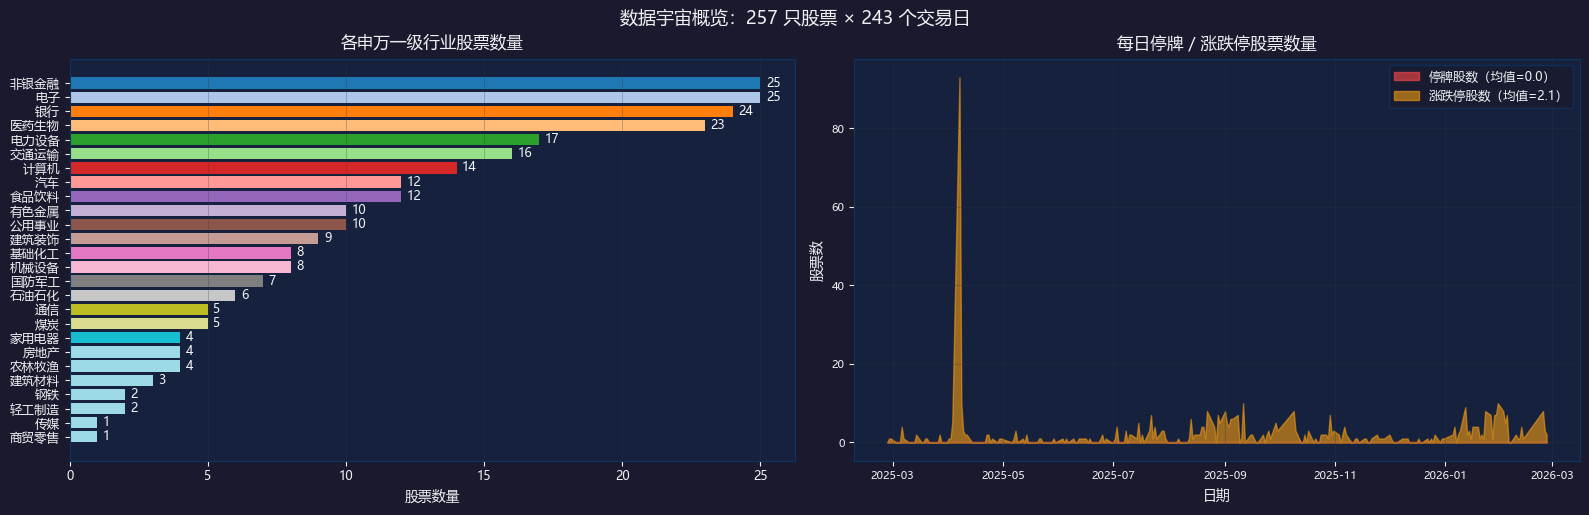

In [4]:
# ── 数据质量统计报告 ─────────────────────────────────────────
print('=' * 60)
print('  数据质量统计报告')
print('=' * 60)

T, N = close.shape
susp_pct  = is_susp.values.mean() * 100
limit_pct = is_limit.values.mean() * 100
nan_pct   = close.isnull().values.mean() * 100

print(f'\n【基本信息】')
print(f'  股票数量     : {N} 只')
print(f'  交易日数量   : {T} 个交易日')
print(f'  日期范围     : {close.index[0].date()} ~ {close.index[-1].date()}')
print(f'  复权方式     : {ADJ_TYPE}（后复权）')

print(f'\n【数据质量】')
print(f'  close NaN 比例  : {nan_pct:.4f}%   ✅' if nan_pct == 0 else f'  close NaN 比例  : {nan_pct:.4f}%')
print(f'  停牌比例        : {susp_pct:.2f}%')
print(f'  涨跌停比例      : {limit_pct:.2f}%')

# 各股票数据完整性检查
stock_nan = close.isnull().sum(axis=0)
print(f'\n【各股完整性】')
print(f'  close 全无缺失  : {(stock_nan == 0).sum()} / {N} 只')
if (stock_nan > 0).any():
    print(f'  有缺失的股票:')
    print(stock_nan[stock_nan > 0].sort_values(ascending=False).head(10))

# ── 行业分布统计 ──────────────────────────────────────────────
print(f'\n【申万一级行业分布】')
ind_count = industry.value_counts().sort_values(ascending=False)
print(f'  行业数量     : {ind_count.shape[0]} 个')
print(f'  行业分布：')
for ind_name, cnt in ind_count.items():
    bar = '█' * cnt
    print(f'  {ind_name:<10} {cnt:>3} 只  {bar}')

# ── 价格统计 ──────────────────────────────────────────────────
print(f'\n【价格统计（最后交易日收盘价）】')
last_close = close.iloc[-1].dropna()
print(f'  均值   : {last_close.mean():.2f}')
print(f'  中位数 : {last_close.median():.2f}')
print(f'  最小值 : {last_close.min():.2f}  ({last_close.idxmin()})')
print(f'  最大值 : {last_close.max():.2f}  ({last_close.idxmax()})')

print(f'\n{"=" * 60}')

# ── 行业分布柱状图 ────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 5), facecolor='#1A1A2E')

# 子图1：行业股票数量
ax1 = axes[0]
ax1.set_facecolor('#16213E')
colors = plt.cm.tab20(range(len(ind_count)))
bars = ax1.barh(ind_count.index[::-1], ind_count.values[::-1], color=colors[::-1])
ax1.set_title('各申万一级行业股票数量', color='#ECF0F1', fontsize=12, pad=8)
ax1.set_xlabel('股票数量', color='#ECF0F1', fontsize=10)
ax1.tick_params(colors='#ECF0F1', labelsize=9)
for spine in ax1.spines.values():
    spine.set_color('#0F3460')
# 添加数值标签
for bar, val in zip(bars, ind_count.values[::-1]):
    ax1.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2,
             str(val), va='center', ha='left', color='#ECF0F1', fontsize=9)
ax1.grid(True, color='#2F3640', alpha=0.4, axis='x', linewidth=0.5)

# 子图2：停牌/涨跌停时序统计
ax2 = axes[1]
ax2.set_facecolor('#16213E')
daily_susp  = is_susp.sum(axis=1)
daily_limit = is_limit.sum(axis=1)
ax2.fill_between(daily_susp.index, daily_susp.values, alpha=0.6,
                 color='#FF4B4B', label=f'停牌股数（均值={daily_susp.mean():.1f}）')
ax2.fill_between(daily_limit.index, daily_limit.values, alpha=0.6,
                 color='#F39C12', label=f'涨跌停股数（均值={daily_limit.mean():.1f}）')
ax2.set_title('每日停牌 / 涨跌停股票数量', color='#ECF0F1', fontsize=12, pad=8)
ax2.set_xlabel('日期', color='#ECF0F1', fontsize=10)
ax2.set_ylabel('股票数', color='#ECF0F1', fontsize=10)
ax2.tick_params(colors='#ECF0F1', labelsize=8)
for spine in ax2.spines.values():
    spine.set_color('#0F3460')
ax2.legend(fontsize=9, facecolor='#1A1A2E', edgecolor='#0F3460', labelcolor='#ECF0F1')
ax2.grid(True, color='#2F3640', alpha=0.4, linewidth=0.5)

plt.tight_layout()
plt.suptitle(f'数据宇宙概览：{N} 只股票 × {T} 个交易日',
             color='#ECF0F1', fontsize=13, y=1.02)
plt.show()

【区间收益率分布】（全部 257 只股票）
  区间涨跌幅  均值   : +22.68%
  区间涨跌幅  中位数 : +4.74%
  区间涨跌幅  最高   : +409.91%  (300308)
  区间涨跌幅  最低   : -40.93%  (688036)
  年化波动率  均值   : 32.08%
  正收益股票占比     : 153 / 257  (59.5%)

  涨幅 Top 10：
    300308  +409.91%  [通信]
    300394  +385.37%  [通信]
    300502  +378.11%  [通信]
    603993  +236.20%  [有色金属]
    002028  +216.47%  [电力设备]
    600362  +168.02%  [有色金属]
    002916  +161.03%  [电子]
    601138  +154.50%  [电子]
    600489  +150.16%  [有色金属]
    600089  +148.82%  [电力设备]

  跌幅 Bottom 10：
    688036  -40.93%  [电子]
    603392  -40.63%  [医药生物]
    000002  -38.52%  [房地产]
    603369  -37.35%  [食品饮料]
    300122  -34.36%  [医药生物]
    301236  -33.03%  [计算机]
    600845  -32.19%  [计算机]
    002304  -32.07%  [食品饮料]
    001965  -28.72%  [交通运输]
    000596  -26.74%  [食品饮料]

【各申万一级行业中位数区间涨跌幅】
  通信         +378.11%  ▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮▮

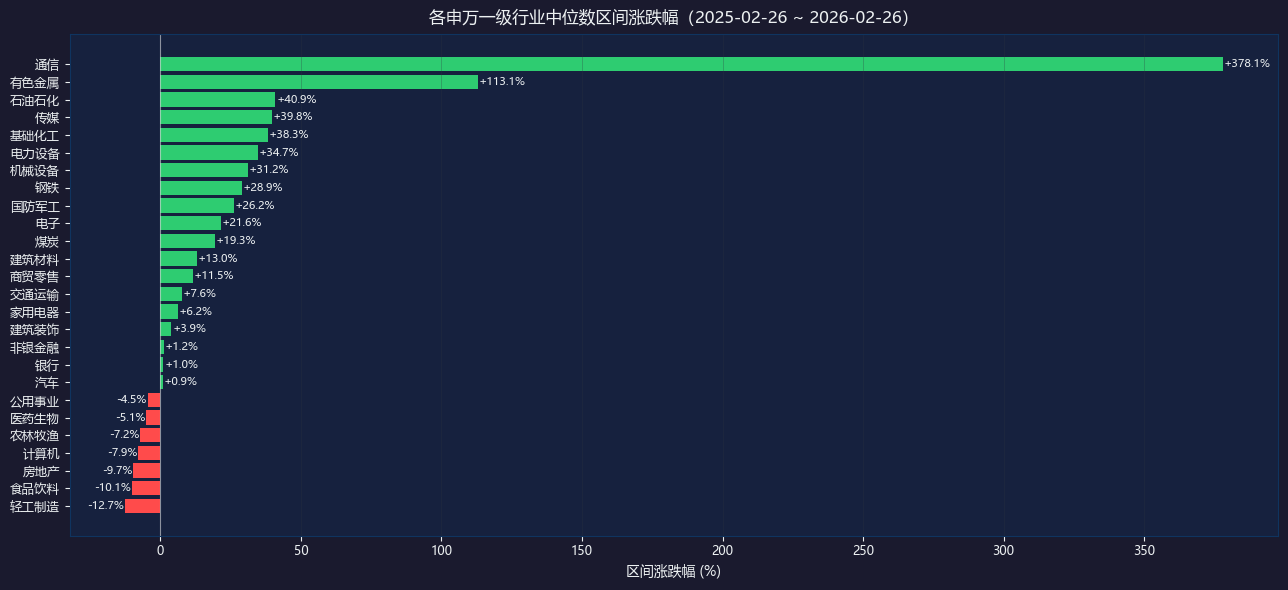

In [5]:
# ── 区间收益率统计（数据宇宙整体表现）──────────────────────
daily_ret = close.pct_change()                  # 日收益率矩阵 (T×N)
cum_ret   = (1 + daily_ret).prod(axis=0) - 1    # 区间累计收益率 (N,)
ann_vol   = daily_ret.std(axis=0) * (252 ** 0.5) # 年化波动率 (N,)

print('【区间收益率分布】（全部 {N} 只股票）'.format(N=N))
print(f'  区间涨跌幅  均值   : {cum_ret.mean()*100:+.2f}%')
print(f'  区间涨跌幅  中位数 : {cum_ret.median()*100:+.2f}%')
print(f'  区间涨跌幅  最高   : {cum_ret.max()*100:+.2f}%  ({cum_ret.idxmax()})')
print(f'  区间涨跌幅  最低   : {cum_ret.min()*100:+.2f}%  ({cum_ret.idxmin()})')
print(f'  年化波动率  均值   : {ann_vol.mean()*100:.2f}%')
print(f'  正收益股票占比     : {(cum_ret > 0).sum()} / {N}  ({(cum_ret > 0).mean()*100:.1f}%)')

# 涨幅 Top10 与 Bottom10
print(f'\n  涨幅 Top 10：')
for sym, r in cum_ret.nlargest(10).items():
    ind = industry.get(sym, '—')
    print(f'    {sym}  {r*100:+.2f}%  [{ind}]')

print(f'\n  跌幅 Bottom 10：')
for sym, r in cum_ret.nsmallest(10).items():
    ind = industry.get(sym, '—')
    print(f'    {sym}  {r*100:+.2f}%  [{ind}]')

# ── 各行业区间涨跌幅 ──────────────────────────────────────────
ind_ret = cum_ret.groupby(industry).median().sort_values(ascending=False)
print(f'\n【各申万一级行业中位数区间涨跌幅】')
for ind_name, r in ind_ret.items():
    bar = '▮' * int(abs(r) * 100)
    sign = '+' if r >= 0 else ''
    print(f'  {ind_name:<10} {sign}{r*100:.2f}%  {bar}')

# ── 行业收益率条形图 ───────────────────────────────────────────
fig, ax = plt.subplots(figsize=(13, 6), facecolor='#1A1A2E')
ax.set_facecolor('#16213E')
colors_bar = ['#2ECC71' if r > 0 else '#FF4B4B' for r in ind_ret.values]
bars = ax.barh(ind_ret.index[::-1], (ind_ret.values * 100)[::-1],
               color=colors_bar[::-1])
ax.axvline(0, color='white', linewidth=0.8, alpha=0.5)
ax.set_title(f'各申万一级行业中位数区间涨跌幅（{close.index[0].date()} ~ {close.index[-1].date()}）',
             color='#ECF0F1', fontsize=12, pad=8)
ax.set_xlabel('区间涨跌幅 (%)', color='#ECF0F1', fontsize=10)
ax.tick_params(colors='#ECF0F1', labelsize=9)
for spine in ax.spines.values():
    spine.set_color('#0F3460')
# 添加数值标签
for bar, val in zip(bars, (ind_ret.values * 100)[::-1]):
    x = bar.get_width()
    ha = 'left' if x >= 0 else 'right'
    offset = 0.3 if x >= 0 else -0.3
    ax.text(x + offset, bar.get_y() + bar.get_height()/2,
            f'{x:+.1f}%', va='center', ha=ha, color='#ECF0F1', fontsize=8)
ax.grid(True, color='#2F3640', alpha=0.4, axis='x', linewidth=0.5)
plt.tight_layout()
plt.show()

## 3. AlphaOps 算子库使用说明

所有算子均支持 `DataFrame` 向量化运算，可自由嵌套组合。

| 类别 | 算子 | 说明 |
|------|------|------|
| 时序 | `Ts_Sum / Ts_Mean / Ts_Max / Ts_Min` | 滑动窗口统计 |
| 时序 | `Ts_Delta(df, period)` | 当前值 - N天前值 |
| 时序 | `Ts_Delay(df, period)` | 数据滞后 N 天 |
| 时序 | `Ts_Std(df, window)` | 滑动窗口标准差 |
| 时序 | `Ts_Rank(df, window)` | 窗口内百分比排名 |
| 时序 | `Ts_Corr(df1, df2, window)` | 滚动相关系数 |
| 截面 | `Rank(df)` | 全市场截面百分比排名 |
| 截面 | `ZScore(df)` | 截面标准化 |
| 截面 | `Scale(df, a=1)` | 截面绝对值缩放至 a |
| 特殊 | `Decay_Linear(df, d)` | 线性加权移动平均 |
| 特殊 | `Neutralize(df, industry)` | 行业中性化（OLS残差法）|

In [6]:
# ─── 快速验证各算子 ───

# 时序算子示例
ma5   = op.Ts_Mean(close, 5)
delta = op.Ts_Delta(close, 20)
std20 = op.Ts_Std(close, 20)
corr  = op.Ts_Corr(volume, close, 10)

# 截面算子示例
rank_factor  = op.Rank(delta)
zscore_factor = op.ZScore(delta)

# 特殊算子示例
decay_factor = op.Decay_Linear(rank_factor, d=5)
neut_factor  = op.Neutralize(rank_factor, industry)

print('✅ 所有算子运行正常')
print(f'   Rank 因子范围: [{rank_factor.stack().min():.4f}, {rank_factor.stack().max():.4f}]')
print(f'   ZScore 因子均值: {zscore_factor.stack().mean():.6f}')
print(f'   Decay_Linear 因子维度: {decay_factor.shape}')
print(f'   Neutralize 后均值: {neut_factor.stack().mean():.6f}  (应接近0)')

✅ 所有算子运行正常
   Rank 因子范围: [0.0039, 1.0000]
   ZScore 因子均值: 0.000000
   Decay_Linear 因子维度: (243, 257)
   Neutralize 后均值: 0.000000  (应接近0)


In [7]:
# ─── 真实数据矩阵预览 ───────────────────────────────────────
print('【close 矩阵预览（前5行 × 前8列）】')
print(close.iloc[:5, :8].to_string())

print(f'\n【数据维度】')
print(f'  close : {close.shape}   (交易日 × 股票)')
print(f'  volume: {volume.shape}')
print(f'  is_susp: {is_susp.shape}')

print(f'\n【ma5 算子输出预览（Ts_Mean 5日移动平均，前5行 × 前5列）】')
print(ma5.iloc[:5, :5].to_string())

【close 矩阵预览（前5行 × 前8列）】
stock       000001  000002  000063  000100  000157  000166  000301  000333
date                                                                      
2025-02-26   11.52    7.84   42.28    4.82    7.62    5.24    9.14   70.12
2025-02-27   11.62    7.81   40.48    4.72    8.12    5.27    9.35   72.48
2025-02-28   11.53    7.75   38.66    4.62    8.00    5.10    9.24   73.05
2025-03-03   11.51    7.79   36.14    4.67    8.12    5.07    9.27   71.00
2025-03-04   11.51    7.64   37.01    4.84    7.90    5.11    9.37   71.97

【数据维度】
  close : (243, 257)   (交易日 × 股票)
  volume: (243, 257)
  is_susp: (243, 257)

【ma5 算子输出预览（Ts_Mean 5日移动平均，前5行 × 前5列）】
stock       000001  000002  000063  000100  000157
date                                              
2025-02-26     NaN     NaN     NaN     NaN     NaN
2025-02-27     NaN     NaN     NaN     NaN     NaN
2025-02-28     NaN     NaN     NaN     NaN     NaN
2025-03-03     NaN     NaN     NaN     NaN     NaN
2025-03-04  11.538  

## 4. 构建 Alpha 因子

以下展示 3 个不同逻辑的因子，支持任意嵌套组合：

In [8]:
# ─── 因子 1：反转动量因子 ───
# 逻辑：近期跌幅越大的股票，均值回归预期更强
# 公式：Rank(-Ts_Delta(close, 5))
factor_reversal = op.Rank(-op.Ts_Delta(close, 5))
print('✅ 因子1 (反转动量): Rank(-Ts_Delta(close, 5))')

# ─── 因子 2：量价背离因子（行业中性化）───
# 逻辑：缩量上涨（量价负相关）是强势信号
# 公式：Neutralize(Rank(-Ts_Corr(volume, close, 10)), industry)
factor_volprice = op.Neutralize(
    op.Rank(-op.Ts_Corr(volume, close, window=10)),
    industry
)
print('✅ 因子2 (量价背离): Neutralize(Rank(-Ts_Corr(volume, close, 10)), industry)')

# ─── 因子 3：综合技术因子 ───
# 逻辑：线性衰减加权的动量信号，ZScore 标准化
# 公式：ZScore(Decay_Linear(Rank(Ts_Delta(close, 10)), 5))
factor_tech = op.ZScore(
    op.Decay_Linear(
        op.Rank(op.Ts_Delta(close, 10)),
        d=5
    )
)
print('✅ 因子3 (技术动量): ZScore(Decay_Linear(Rank(Ts_Delta(close, 10)), 5))')

✅ 因子1 (反转动量): Rank(-Ts_Delta(close, 5))
✅ 因子2 (量价背离): Neutralize(Rank(-Ts_Corr(volume, close, 10)), industry)
✅ 因子3 (技术动量): ZScore(Decay_Linear(Rank(Ts_Delta(close, 10)), 5))


## 5. 单因子回测

只需传入因子矩阵和行情数据，即可获得完整回测结果：

In [9]:
# ── 回测公共配置 ──────────────────────────────────────────────────
# 修改这里即可统一影响下方所有回测
REBALANCE_FREQ = 5        # 调仓频率：5 = 每周
TOP_N          = 50       # 持仓股数（约占 257 只宇宙的 20%）
WEIGHT_METHOD  = 'equal'  # 'equal' | 'factor_weighted'
COST_RATE      = 0.0015   # 单边交易成本（0.15%）

# ── 预处理参数（v2.0）────────────────────────────────────────────
# delay=d 的语义：用 T-d 日因子预测 T 日收益
# delay=1（推荐）：T-1 日因子 → T 日建仓 → 赚 T 日收益，严格无未来函数
# delay=0：T 日因子预测 T 日收益，存在 look-ahead bias，仅供研究对比
DELAY    = 1     # 1 = T-1日因子预测T日收益（标准配置，推荐）
DECAY    = 0     # 0 = 不衰减；>0 = Decay_Linear 平滑窗口
INDUSTRY = None  # None = 不做行业中性化；传入 industry Series = OLS中性化


print(f'回测配置：rebalance_freq={REBALANCE_FREQ}, top_n={TOP_N}, '
      f'weight={WEIGHT_METHOD}, cost={COST_RATE}')
print(f'预处理：delay={DELAY}（T-{DELAY}日因子预测T日收益）, '
      f'decay={DECAY}, industry={INDUSTRY}')
print(f'回测时间范围：start_date={START_DATE}, end_date={END_DATE}')

回测配置：rebalance_freq=5, top_n=50, weight=equal, cost=0.0015
预处理：delay=1（T-1日因子预测T日收益）, decay=0, industry=None
回测时间范围：start_date=2025-02-26, end_date=2026-02-26


In [10]:
# ─── 回测因子 1：反转动量因子 ───
print('=' * 55)
print('  回测：反转动量因子')
print('=' * 55)

engine1 = VectorEngine(
    factor         = factor_reversal,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = REBALANCE_FREQ,
    top_n          = TOP_N,
    weight_method  = WEIGHT_METHOD,
    cost_rate      = COST_RATE,
    delay          = DELAY,
    decay          = DECAY,
    industry       = INDUSTRY,
    start_date     = START_DATE,
    end_date       = END_DATE,
)
result1 = engine1.run()
result1.print_summary()

  回测：反转动量因子
[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=1, decay=0, neutralize=否
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！


╔═════════════════════════════════╗
║ QuantAlpha Engine — 回测绩效报告 ║
╠═════════════════════════════════╣
║  年化收益率     │      +11.04%  ║
║  年化波动率     │      +18.86%  ║
║  Sharpe Ratio   │      +0.6509  ║
║  Calmar Ratio   │      +0.7223  ║
║  最大回撤       │      -15.28%  ║
║  IC 均值        │      +0.0372  ║
║  IC 标准差      │      +0.1945  ║
║  ICIR           │      +3.0375  ║
║  IC 胜率        │      +56.12%  ║
║  IC t-stat      │      +2.9457  ║
║  日均换手率     │      +13.30%  ║
║  年化手续费     │       +5.03%  ║
║  Fitness        │      +0.5929  ║
╚═════════════════════════════════╝



  回测：量价背离因子（行业中性化）
[VectorEngine] 开始对齐数据...
[VectorEngine] 数据规模：243 个交易日 × 257 只股票  [2025-02-26 ~ 2026-02-26]
[VectorEngine] 预处理参数：delay=1, decay=0, neutralize=否
[VectorEngine] 构建持仓权重矩阵...
[VectorEngine] 计算 IC 序列...
[VectorEngine] 汇总绩效指标...
[VectorEngine] 回测完成！


╔═════════════════════════════════╗
║ QuantAlpha Engine — 回测绩效报告 ║
╠═════════════════════════════════╣
║  年化收益率     │      +20.07%  ║
║  年化波动率     │      +13.58%  ║
║  Sharpe Ratio   │      +1.4160  ║
║  Calmar Ratio   │      +2.4309  ║
║  最大回撤       │       -8.26%  ║
║  IC 均值        │      +0.0118  ║
║  IC 标准差      │      +0.0855  ║
║  ICIR           │      +2.1876  ║
║  IC 胜率        │      +52.79%  ║
║  IC t-stat      │      +2.1035  ║
║  日均换手率     │      +12.34%  ║
║  年化手续费     │       +4.66%  ║
║  Fitness        │      +1.8060  ║
╚═════════════════════════════════╝



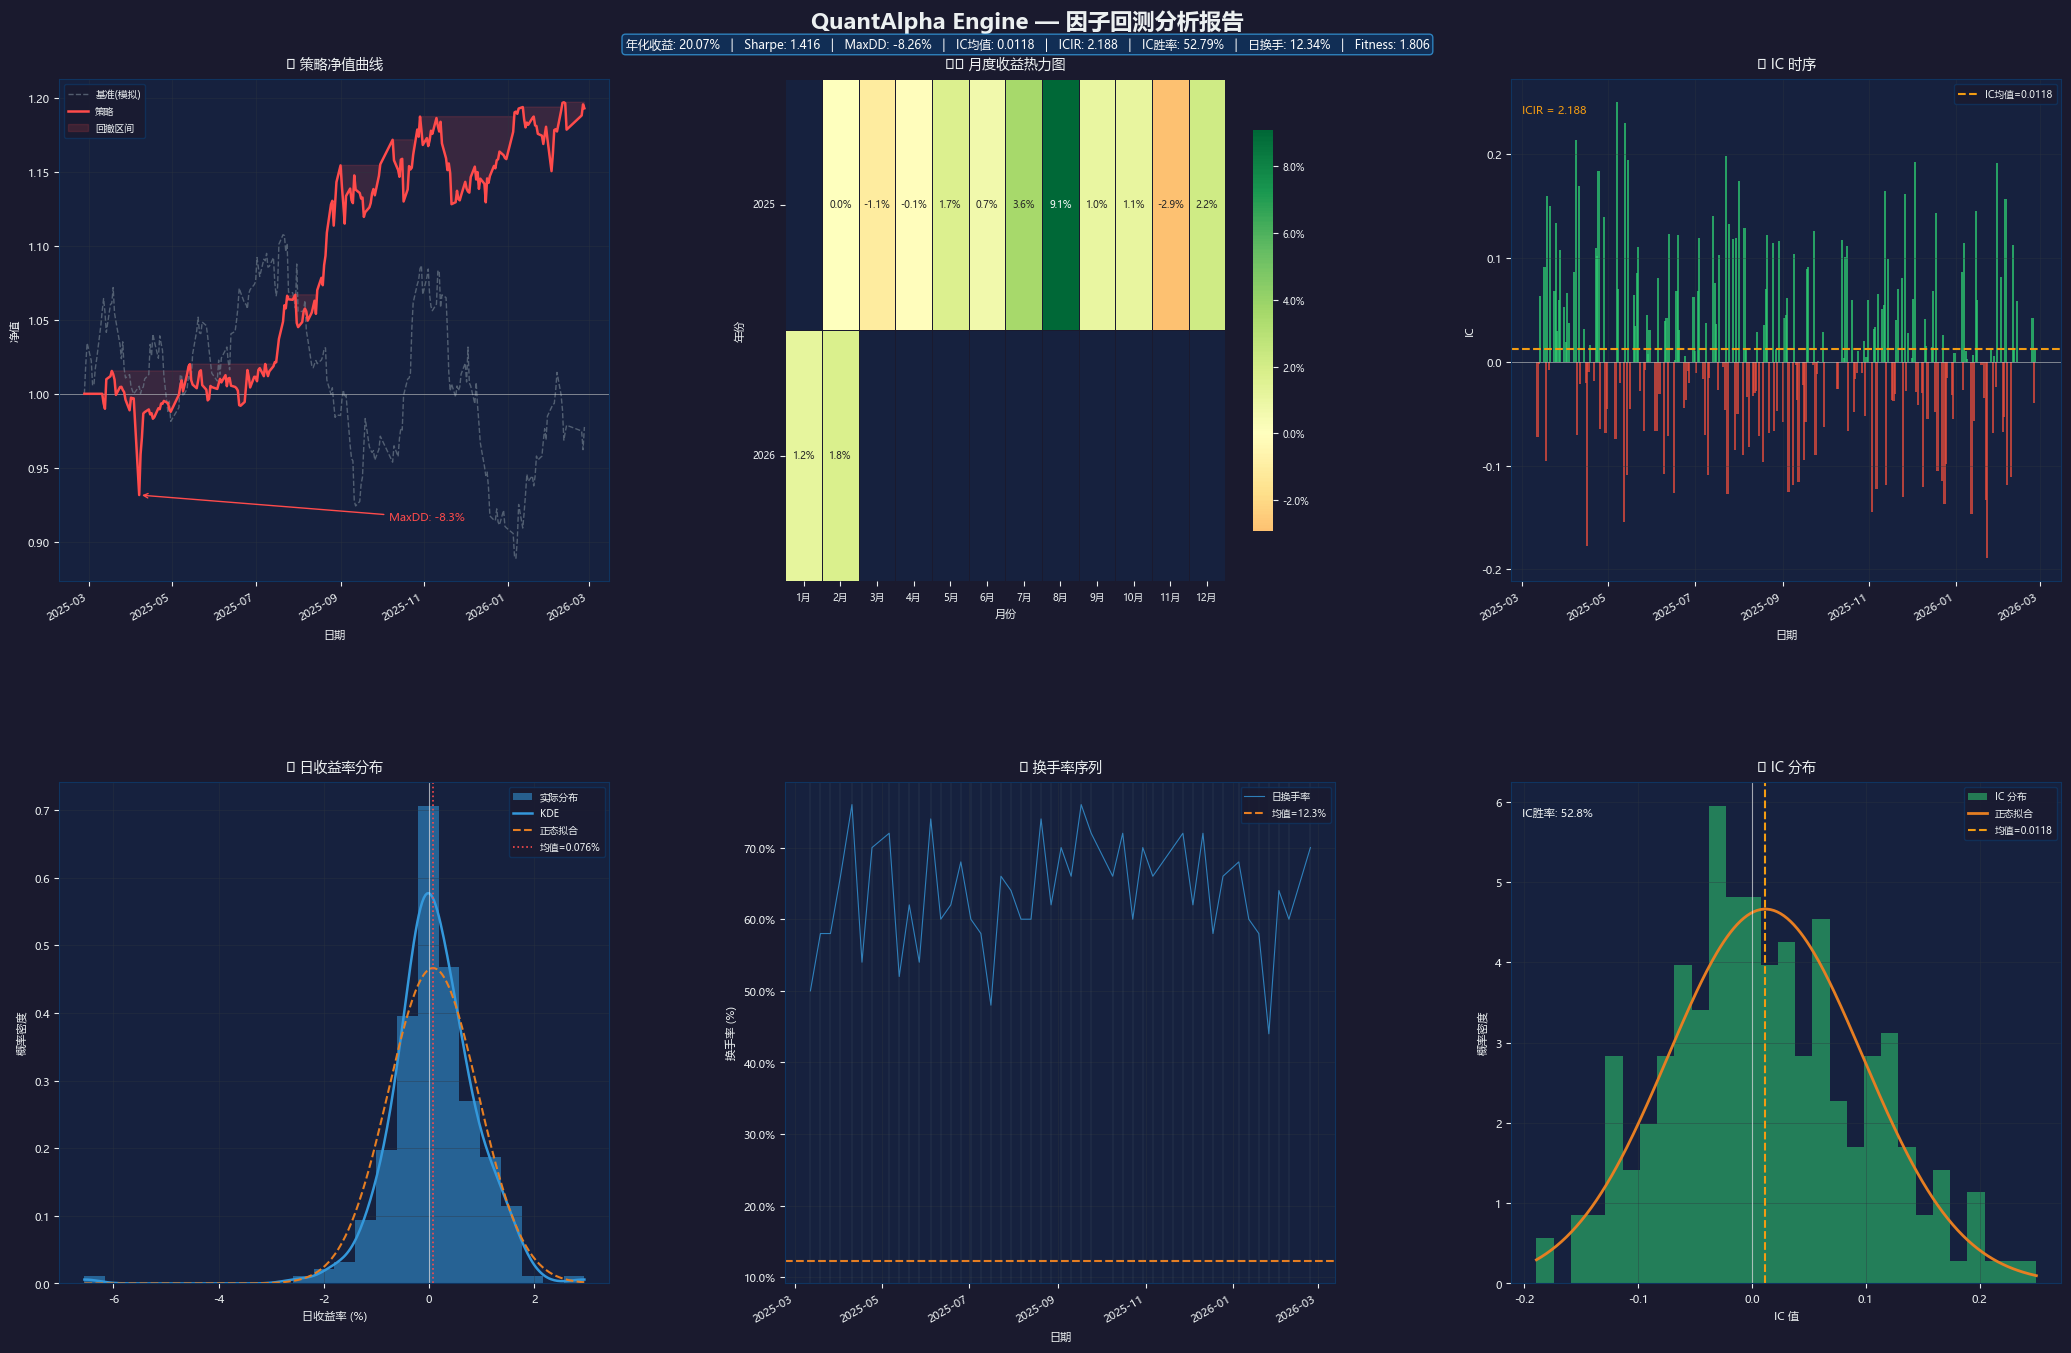

In [11]:
# ─── 回测因子 2：量价背离因子 ───
print('=' * 55)
print('  回测：量价背离因子（行业中性化）')
print('=' * 55)

engine2 = VectorEngine(
    factor         = factor_volprice,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = REBALANCE_FREQ,
    top_n          = TOP_N,
    weight_method  = WEIGHT_METHOD,
    cost_rate      = COST_RATE,
    delay          = DELAY,
    decay          = DECAY,
    industry       = INDUSTRY,
    start_date     = START_DATE,
    end_date       = END_DATE,
)
result2 = engine2.run()
result2.print_summary()
result2.plot()

In [ ]:
# ─── 回测因子 3：综合技术因子 ───
print('=' * 55)
print('  回测：综合技术因子')
print('=' * 55)

engine3 = VectorEngine(
    factor         = factor_tech,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = REBALANCE_FREQ,
    top_n          = TOP_N,
    weight_method  = WEIGHT_METHOD,
    cost_rate      = COST_RATE,
    delay          = DELAY,
    decay          = DECAY,
    industry       = INDUSTRY,
    start_date     = START_DATE,
    end_date       = END_DATE,
)
result3 = engine3.run()
result3.print_summary()
result3.plot()

In [ ]:
# 汇总对比表
comparison = pd.DataFrame({
    '反转动量':  result1.metrics,
    '量价背离':  result2.metrics,
    '技术动量':  result3.metrics,
}).T

# 选择核心指标展示
key_cols = ['年化收益率', '年化波动率', 'Sharpe_Ratio', '最大回撤',
            'IC_Mean', 'ICIR', 'IC_胜率', '日均换手率', 'Fitness']
display_df = comparison[key_cols].copy()

# 格式化显示
pct_cols = ['年化收益率', '年化波动率', '最大回撤', 'IC_胜率', '日均换手率']
for col in pct_cols:
    display_df[col] = display_df[col].apply(lambda v: f'{v*100:.2f}%' if pd.notna(v) else 'N/A')
for col in ['Sharpe_Ratio', 'IC_Mean', 'ICIR', 'Fitness']:
    display_df[col] = display_df[col].apply(lambda v: f'{v:.4f}' if pd.notna(v) else 'N/A')

print('\n=== 三因子绩效对比 ===')
print(display_df.to_string())

In [ ]:
# 净值曲线对比图
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#1A1A2E')
ax.set_facecolor('#16213E')
ax.spines['bottom'].set_color('#0F3460')
ax.spines['left'].set_color('#0F3460')
ax.spines['top'].set_color('#0F3460')
ax.spines['right'].set_color('#0F3460')
ax.tick_params(colors='#ECF0F1')

navs = {
    '反转动量': (result1.nav, '#FF4B4B'),
    '量价背离': (result2.nav, '#2ECC71'),
    '技术动量': (result3.nav, '#3498DB'),
}

for label, (nav, color) in navs.items():
    ax.plot(nav.index, nav.values, label=label, color=color, linewidth=1.8)

ax.axhline(1.0, color='white', linewidth=0.6, alpha=0.4, linestyle='--')
ax.set_title('三因子净值曲线对比', color='#ECF0F1', fontsize=13, pad=10)
ax.set_xlabel('日期', color='#ECF0F1', fontsize=10)
ax.set_ylabel('净值', color='#ECF0F1', fontsize=10)
ax.legend(fontsize=9, facecolor='#1A1A2E', edgecolor='#0F3460',
          labelcolor='#ECF0F1')
ax.grid(True, color='#2F3640', alpha=0.5, linewidth=0.5)
plt.tight_layout()
plt.show()

## 7. 高级用法：多因子合成 + 因子加权

将多个因子线性加权合成复合 Alpha，并使用**因子值比例分配权重**（非等权）：

In [ ]:
# 多因子等权合成
alpha_combo = (
    0.4 * op.Rank(factor_reversal) +
    0.4 * op.Rank(factor_volprice) +
    0.2 * op.Rank(factor_tech)
)

print('=' * 55)
print('  回测：多因子合成 Alpha（因子值加权持仓）')
print('=' * 55)
print('  因子: 0.4×Rank(反转) + 0.4×Rank(量价) + 0.2×Rank(技术)')
print('  （本策略使用更低调仓频率 + 更集中持仓 + 因子值加权）')

engine_combo = VectorEngine(
    factor         = alpha_combo,
    close          = close,
    is_suspended   = is_susp,
    is_limit       = is_limit,
    rebalance_freq = 10,                  # 每2周调仓（独立于公共配置）
    top_n          = 30,                  # 精选 30 只（约占宇宙 12%，独立于公共配置）
    weight_method  = 'factor_weighted',   # 因子值加权（非等权）
    cost_rate      = COST_RATE,           # 复用公共成本配置
    delay          = DELAY,               # 复用公共预处理配置
    decay          = DECAY,
    industry       = INDUSTRY,
)
result_combo = engine_combo.run()
result_combo.print_summary()
result_combo.plot()

## 9. 单独调用绩效指标

`Performance` 模块可以独立使用，对任意收益序列计算指标：

In [ ]:
# ─── 当前 Notebook 已使用真实数据 ───
# 数据来自：rawdata/repository（DataRepository 本地仓库）
# 数据加载流程（见 Cell 2）：
#   1. RepositoryDataLoader.load() → 加载全部 OHLCV
#   2. 过滤 close NaN = 0 的股票
#   3. 过滤有申万一级行业信息的股票
#   4. 取交集 → 最终宇宙 ~257 只股票

# ── Performance 模块独立使用示例 ────────────────────────────
# Performance 为纯静态方法类，可独立对任意收益/净值序列计算指标

nav     = result1.nav            # 净值序列 (pd.Series)
returns = result1.daily_returns  # 日收益率序列 (pd.Series)

ann_ret = Performance.calc_annualized_return(nav)
ann_vol = Performance.calc_annualized_volatility(returns)
sharpe  = Performance.calc_sharpe(returns)
mdd     = Performance.calc_max_drawdown(nav)

print('【Performance 模块独立调用示例（反转动量因子）】')
print(f'  年化收益率 : {ann_ret*100:+.2f}%')
print(f'  年化波动率 : {ann_vol*100:.2f}%')
print(f'  夏普比率   : {sharpe:.4f}')
print(f'  最大回撤   : {mdd*100:.2f}%')

print('\n💡 Performance 支持独立使用，传入净值/日收益 Series 即可计算单项指标：')
print('   Performance.calc_annualized_return(nav)         ← 年化收益率')
print('   Performance.calc_annualized_volatility(returns) ← 年化波动率')
print('   Performance.calc_sharpe(returns)                ← 夏普比率')
print('   Performance.calc_max_drawdown(nav)              ← 最大回撤')

---

## 算子速查表

```python
from quant_alpha_engine.ops import AlphaOps as op

# 时序类
op.Ts_Sum(df, window)        # 滑动求和
op.Ts_Mean(df, window)       # 滑动均值（移动平均）
op.Ts_Max(df, window)        # 滑动最大值
op.Ts_Min(df, window)        # 滑动最小值
op.Ts_Std(df, window)        # 滑动标准差
op.Ts_Delta(df, period)      # df - df.shift(period)
op.Ts_Delay(df, period)      # df.shift(period) 数据滞后
op.Ts_Rank(df, window)       # 窗口内时序百分比排名 [0,1]
op.Ts_Corr(df1, df2, window) # 滚动相关系数 [-1,1]

# 截面类（每日横截面操作）
op.Rank(df)                  # 截面百分比排名 [0,1]
op.ZScore(df)                # 截面 Z-Score 标准化
op.Scale(df, a=1)            # 截面绝对值之和缩放至 a

# 特殊类
op.Decay_Linear(df, d)       # 线性加权衰减移动平均（WQ核心算子）
op.Neutralize(df, industry)  # 行业中性化（OLS残差法）
```

---

## §12. 参数调优（Parameter Tuning）

`ParameterTuner` 对**因子参数 × 回测参数**做**笛卡尔积搜索**，自动多目标排序并展示 Top-N 最优组合。

| 功能 | 说明 |
|------|------|
| 因子参数搜索 | `factor_params` → 字典列表，传入因子工厂函数 |
| 回测参数搜索 | `backtest_params` → VectorEngine 参数（rebalance_freq、top_n 等）|
| 多目标排序 | `opt_target` → 支持多指标联合排序（`'desc'` / `'asc'`）|
| 并行执行 | `n_jobs=N` → `ThreadPoolExecutor` 多线程加速 |
| 结果筛选 | `print_top(n)` → Jupyter 中渲染彩色 HTML 表格 |
| 单组详查 | `get_result(idx)` → 获取完整 `BacktestResult`，支持 `.plot()` / `.print_summary()` |

In [ ]:
# ── §12-G（续）用 get_result_by_id 按参数字符串精确查询 ─────────────────
# combo_id 格式：f_period=5|f_use_zscore=False|b_rebalance_freq=1|b_top_n=30
# 可从 tuner2.results_df 直接读取或手动拼写

target_id = tuner2.results_df.iloc[0]['combo_id']   # 取 Rank-1 的 id
print(f'查询 combo_id：{target_id}')
print()

r_by_id = tuner2.get_result_by_id(target_id)
r_by_id.print_summary()
r_by_id.plot()

In [ ]:
# ── §12-G  反转因子调优（较小搜索空间，快速演示）────────────────────────
tuner2 = ParameterTuner(
    factor_fn       = reversal_factor,
    close           = close,
    volume          = volume,
    high            = high,
    low             = low,
    is_suspended    = is_susp,
    is_limit        = is_limit,
    factor_params   = {
        'period':     [3, 5, 10, 20],   # 回看周期
        'use_zscore': [False, True],     # Rank vs ZScore
    },
    backtest_params = {
        'rebalance_freq': [1, 5],
        'top_n':          [30, 50],
    },
    opt_target = {
        'Sharpe_Ratio': 'desc',
        'IC_Mean':      'desc',
    },
    n_jobs  = 4,
    verbose = True,
)

tuner2.run()
print(f'\n✅ 反转因子调优完成，共 {len(tuner2.combos)} 个组合')
tuner2.print_top(5)

### §12-G  第二个示例：反转因子参数搜索 + `get_result_by_id` 精确查询

In [ ]:
# ── §12-F（续）Sharpe Ratio 参数敏感性热力图 ─────────────────────────────
# 以 window vs vol_window 为轴，Sharpe_Ratio 取各 rebalance_freq 的均值
df = tuner.results_df.copy()

# 提取因子参数列（f_ 前缀）为数值
if 'f_window' in df.columns and 'f_vol_window' in df.columns:
    pivot_sharpe = df.pivot_table(
        values='Sharpe_Ratio',
        index='f_window',
        columns='f_vol_window',
        aggfunc='mean'
    )
    pivot_mdd = df.pivot_table(
        values='最大回撤',
        index='f_window',
        columns='f_vol_window',
        aggfunc='mean'
    )

    fig, axes = plt.subplots(1, 2, figsize=(13, 4.5), facecolor='#1A1A2E')

    for ax, pivot, title, cmap, fmt in [
        (axes[0], pivot_sharpe, 'Sharpe Ratio 均值\n(window vs vol_window)', 'YlGn',  '{:.3f}'),
        (axes[1], pivot_mdd,    '最大回撤 均值\n(window vs vol_window)',    'RdYlGn', '{:.1%}'),
    ]:
        ax.set_facecolor('#16213E')
        import numpy as np
        data = pivot.values
        im = ax.imshow(data, cmap=cmap, aspect='auto')
        ax.set_xticks(range(len(pivot.columns)))
        ax.set_yticks(range(len(pivot.index)))
        ax.set_xticklabels([f'vol_w={c}' for c in pivot.columns],
                           color='#ECF0F1', fontsize=9)
        ax.set_yticklabels([f'w={r}' for r in pivot.index],
                           color='#ECF0F1', fontsize=9)
        ax.set_title(title, color='#ECF0F1', fontsize=10, pad=8)
        # 标注数值
        for ri in range(data.shape[0]):
            for ci in range(data.shape[1]):
                val = data[ri, ci]
                if not np.isnan(val):
                    ax.text(ci, ri, fmt.format(val),
                            ha='center', va='center',
                            color='black', fontsize=9, fontweight='bold')
        for sp in ax.spines.values():
            sp.set_color('#0F3460')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.suptitle('参数敏感性热力图（各格为所有回测参数组合的均值）',
                 color='#ECF0F1', fontsize=11, y=1.01)
    plt.tight_layout()
    plt.show()
else:
    print('提示：热力图需要 f_window 与 f_vol_window 列，请确认因子参数命名。')

In [ ]:
# ── §12-F  查看全量结果 DataFrame ────────────────────────────────────────
print(f'完整结果表（共 {len(tuner.results_df)} 行）：')
display(tuner.summary())

### §12-F  全量结果表 + Sharpe / 最大回撤参数敏感性热力图

In [ ]:
# ── §12-E  Top-3 参数组合净值曲线对比 ───────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#1A1A2E')
ax.set_facecolor('#16213E')

colors   = ['#FF4B4B', '#2ECC71', '#3498DB']
n_show   = min(3, len(tuner.combos))

for i in range(n_show):
    r        = tuner.get_result(i)
    nav      = r.nav.dropna()
    combo_id = tuner.results_df.iloc[i]['combo_id']
    sharpe   = tuner.results_df.iloc[i]['Sharpe_Ratio']
    ann_ret  = tuner.results_df.iloc[i]['年化收益率']
    label    = f'Rank{i+1}  Sharpe={sharpe:.3f}  年化={ann_ret*100:+.1f}%\n[{combo_id}]'
    ax.plot(nav.index, nav.values, label=label, color=colors[i], linewidth=1.8)

ax.axhline(1.0, color='white', linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_title('Top 3 参数组合净值曲线对比', color='#ECF0F1', fontsize=12, pad=10)
ax.set_xlabel('日期',  color='#ECF0F1', fontsize=9)
ax.set_ylabel('净值',  color='#ECF0F1', fontsize=9)
ax.legend(fontsize=7.5, facecolor='#1A1A2E', edgecolor='#0F3460',
          labelcolor='#ECF0F1', loc='upper left')
ax.tick_params(colors='#ECF0F1', labelsize=7)
ax.grid(True, color='#2F3640', alpha=0.5, linewidth=0.5)
for sp in ax.spines.values():
    sp.set_color('#0F3460')

plt.tight_layout()
plt.show()

### §12-E  Top-3 净值曲线对比

In [ ]:
# ── §12-D（续）最优组合 6 子图详细报告 ──────────────────────────────────
best_result.plot()

In [ ]:
# ── §12-D  get_result(0) → Rank-1 组合的完整 BacktestResult ────────────
print('=' * 55)
print('  Best Combo（Rank 1）— 完整绩效报告')
print('=' * 55)
best_combo_id = tuner.results_df.iloc[0]['combo_id']
print(f'  参数组合：{best_combo_id}')
print()

best_result = tuner.get_result(0)   # 按排名索引取结果
best_result.print_summary()

### §12-D  最优组合完整绩效报告 + 图表

In [ ]:
# ── §12-C（续）参数分布统计 ─────────────────────────────────────────────
top5 = tuner.top(5)
print('Top-5 参数组合详情：')
print('─' * 70)
for i in range(min(5, len(tuner.combos))):
    row = tuner.results_df.iloc[i]
    combo_id = row['combo_id']
    sharpe   = row['Sharpe_Ratio']
    mdd      = row['最大回撤']
    ann_ret  = row['年化收益率']
    icir     = row['ICIR']
    print(f'  Rank {i+1}  [{combo_id}]')
    print(f'          年化收益={ann_ret*100:+.2f}%  Sharpe={sharpe:.4f}  '
          f'最大回撤={mdd*100:.2f}%  ICIR={icir:.4f}')
print('─' * 70)

In [ ]:
# ── §12-C  彩色表格展示 Top-5（Jupyter 中自动渲染 HTML Styler）────────
tuner.print_top(5)

### §12-C  展示 Top-5 最优组合

In [ ]:
# ── §12-B  ParameterTuner 配置 & 运行 ───────────────────────────────
tuner = ParameterTuner(
    factor_fn       = momentum_factor,
    close           = close,
    volume          = volume,
    high            = high,
    low             = low,
    is_suspended    = is_susp,
    is_limit        = is_limit,
    industry        = None,           # 不做行业中性化
    # ── 因子参数搜索空间 ──────────────────────────────
    factor_params   = {
        'window':     [10, 20, 30],   # 动量回看窗口
        'vol_window': [5, 10],        # 波动率估计窗口
        'use_rank':   [True],         # 固定使用截面排名
    },
    # ── 回测参数搜索空间 ──────────────────────────────
    backtest_params = {
        'rebalance_freq': [1, 5],     # 日频 vs 周频
        'top_n':          [20, 30],   # 持仓集中度
        'cost_rate':      [0.001, 0.0015],  # 低成本 vs 标准成本
    },
    # ── 多目标优化目标（优先级从左到右）─────────────
    opt_target      = {
        'Sharpe_Ratio': 'desc',   # 夏普越高越好
        '最大回撤':     'asc',    # 回撤越小越好（存储为负数，asc=绝对值最小）
    },
    n_jobs  = 4,      # 4 线程并行
    verbose = True,   # 打印进度
)

tuner.run()
print(f'\n✅ 调优完成，共评估 {len(tuner.combos)} 个参数组合')

### §12-B  创建调优器并运行（风险调整动量因子）

搜索空间：`window × vol_window × rebalance_freq × top_n × cost_rate` = **3 × 2 × 2 × 2 × 2 = 48 个组合**

In [ ]:
# ── §12-A  导入 ParameterTuner + 定义因子工厂函数 ────────────────────
from quant_alpha_engine.tuning import ParameterTuner

# ── 因子工厂函数：风险调整动量（RiskAdjMomentum）────────────────────────
# 参数化：window（动量窗口）、vol_window（波动率窗口）、use_rank（是否截面排名）
def momentum_factor(close, volume, high, low,
                    window=20, vol_window=10, use_rank=True):
    """
    风险调整动量因子
    公式：Rank( Ts_Delta(close,window) / Ts_Std(close,vol_window) )
    """
    mom = op.Ts_Delta(close, window)
    vol = op.Ts_Std(close, vol_window).replace(0, float('nan'))
    f   = mom / vol
    return op.Rank(f) if use_rank else f

# ── 因子工厂函数 2：反转因子（简单，用于第二个调优示例）──────────────────
def reversal_factor(close, volume, high, low,
                    period=5, use_zscore=False):
    """
    短周期反转因子
    公式：Rank(-Ts_Delta(close, period))  或  ZScore(-Ts_Delta(close, period))
    """
    f = -op.Ts_Delta(close, period)
    return op.ZScore(f) if use_zscore else op.Rank(f)

print('✅ 因子工厂函数定义完成')
print('  momentum_factor : window × vol_window × use_rank')
print('  reversal_factor : period × use_zscore')